# Error Propagation using Random Gaussian Numbers

Example calculation of propagating uncertainties, both when adding and multiplying number, and also in the general case. The propagation can be done both analytically (using the error propagation formula) and also using simulation.

The example is based on FIRST doing the error propagation **analytically**, and then verifying it by running a so-called Monte-Carlo (MC) program, which uses random numbers for propagating errors.


## References:
- Barlow: page 48-61
- Bevington: page 36-48

## Author(s), contact(s), and dates:
- Author: Troels C. Petersen (NBI)
- Email:  petersen@nbi.dk
- Date:   8th of November 2022

***

DO THE FOLLOWING ANALYTICAL EXERCISE FIRST!!!

1. A class of students estimate by eye, that the length of the table in Auditorium A is $L = (3.5\pm 0.4)$m, and that the width is $W = (0.8\pm 0.2)$m.

   Assuming that there is no correlation between these two measurements, calculate ANALYTICALLY what the Perimeter (P), area (A), and diagonal (D) length is including (propagated) uncertainties. Repeat the calculation, given that the correlation between length and width is $\rho(L,W) = 0.5$ - not an unreasonable number, given that they are estimated by the same (uncertain) scale.
   
NOTE: This is a complete standard problem, that you will be asked to solve again and again in the course. For this reason, make sure that you understand how to do it, and become good at doing it reasonably fast.

In [15]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
from scipy import stats
import sys                                             # Modules to see files and folders in directories

In [16]:
sys.path.append('C:\\Users\\Simon\\PycharmProjects\\Projects\\Projects\\AppStat2022\\External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

## Error propagation - Simulation

Now we want to try to see, if we can solve the above error propagation problem using simulation. The method is relatively straight forward: You simply take "realistic" values of the input parameters x (here Length (x1) and Width (x2)), calculate the resulting value y (here Perimeter, Area, and Diagonal), and do this many times. The resulting distribution of y should be centered around the value y(x1,x2), and the standard deviation should reflect the uncertainty in y from the uncertainties in the input variables.

This is a much more clumsy way of calculating the uncertainty, but comes with the advantage, that if the resulting uncertainty is not Gaussian, then one can actually see this (i.e. it avoids the assumptions used in the usual error propagation formula).

In [17]:
# First we set the parameters of the program:
N_exp = 100000           # Number of "experiments" (i.e. drawing from random distributions)
save_plots = False
r = np.random
r.seed(42)

Define parameters for two random numbers (Gaussianly distributed):

In [18]:
L   =  1.9535426
dL  =  0#0.17525 / 100
P   =  2.807179
dP  =  0.004366
rho12 =  0         # Correlation parameter!
n_target = 1           # number of output variables

In [19]:
if not (-1.0 <= rho12 <= 1.0): 
    raise ValueError(f"Correlation factor not in interval [-1,1], as it is {rho12:6.2f}")

Now we calculate numbers that allows the transform from uncorrelated variables `u` and `v` to correlated random numbers `x1` and `x2` below (see Barlow page 42-44 for method).

Essentially, the method is to "rotate" `u` and `v`, and the formulae simply controls the amount of rotation one needs to get the correlation wanted.

In [20]:
# Define the parameters needed for the transformation:
theta = 0.5 * np.arctan( 2.0 * rho12 * dL * dP / ( np.square(dL) - np.square(dP) ) )
sigu = np.sqrt( dL**2)
sigv = np.sqrt(dP ** 2)


# Produce random numbers with the (possible) correlation:
u = r.normal(0.0, sigu, N_exp)
v = r.normal(0.0, sigv, N_exp)
L_all = L + np.cos(theta)*u - np.sin(theta)*v
P_all = P + np.sin(theta)*u + np.cos(theta)*v
LP_all = np.array([L_all, P_all])

g_pendulum = (4 * np.pi ** 2) * L_all / P_all ** 2 

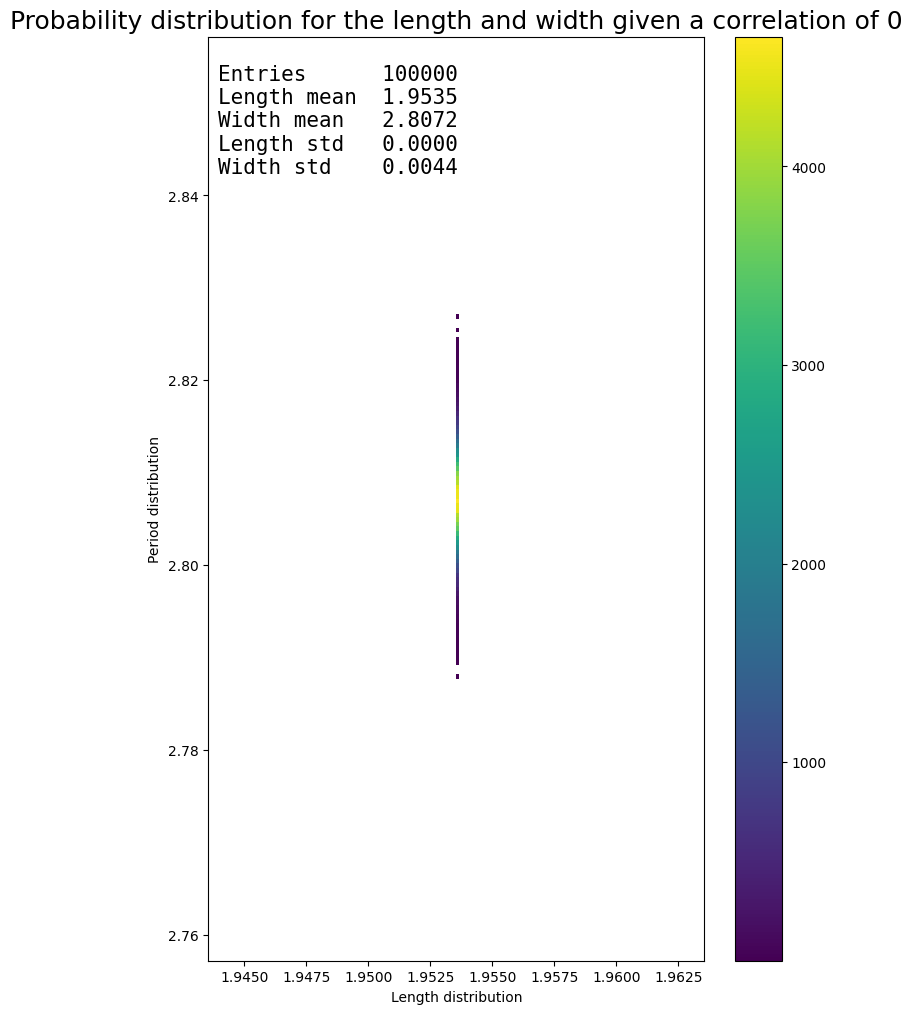

In [21]:
## Plot the x1-x2 (length width) distribution as a 2d histogram

Lrange, Wrange = [(L-0.01,L+0.01), (P-0.05,P+0.05)]  # plotting range
Lbins, Wbins = (200, 200)  # make sure ranges can be nicely divided by number of bins. Here, almost 10 per bins for L, more than 10 per bin for W

fig, ax = plt.subplots(figsize = (8,12))

counts, x_edges, y_edges, im = ax.hist2d(L_all, P_all, bins = (Lbins, Wbins), range = (Lrange, Wrange), cmin = 1); #if N<cmin in a bin, it will not be displayed
fig.colorbar(im, ax = ax)

ax.set_title(f'Probability distribution for the length and width given a correlation of {rho12}', fontsize = 18)
ax.set(xlabel = 'Length distribution', ylabel = 'Period distribution')


d = {'Entries': N_exp,
    'Length mean': L_all.mean(),
    'Width mean': P_all.mean(),
    'Length std': L_all.std(),
    'Width std': P_all.std() 
}
text = nice_string_output(d, extra_spacing=2, decimals=4)
add_text_to_ax(0.02, 0.97, text, ax, fontsize=15);



#fig.tight_layout()


In [22]:
def gaussian(x, N, range, bins, mu, sigma):
    binwidth = (range[1] - range[0]) / bins
    return binwidth * N / (sigma * np.sqrt(2 * np.pi)) * np.exp (- 1/2 * np.power((x - mu) / sigma, 2))



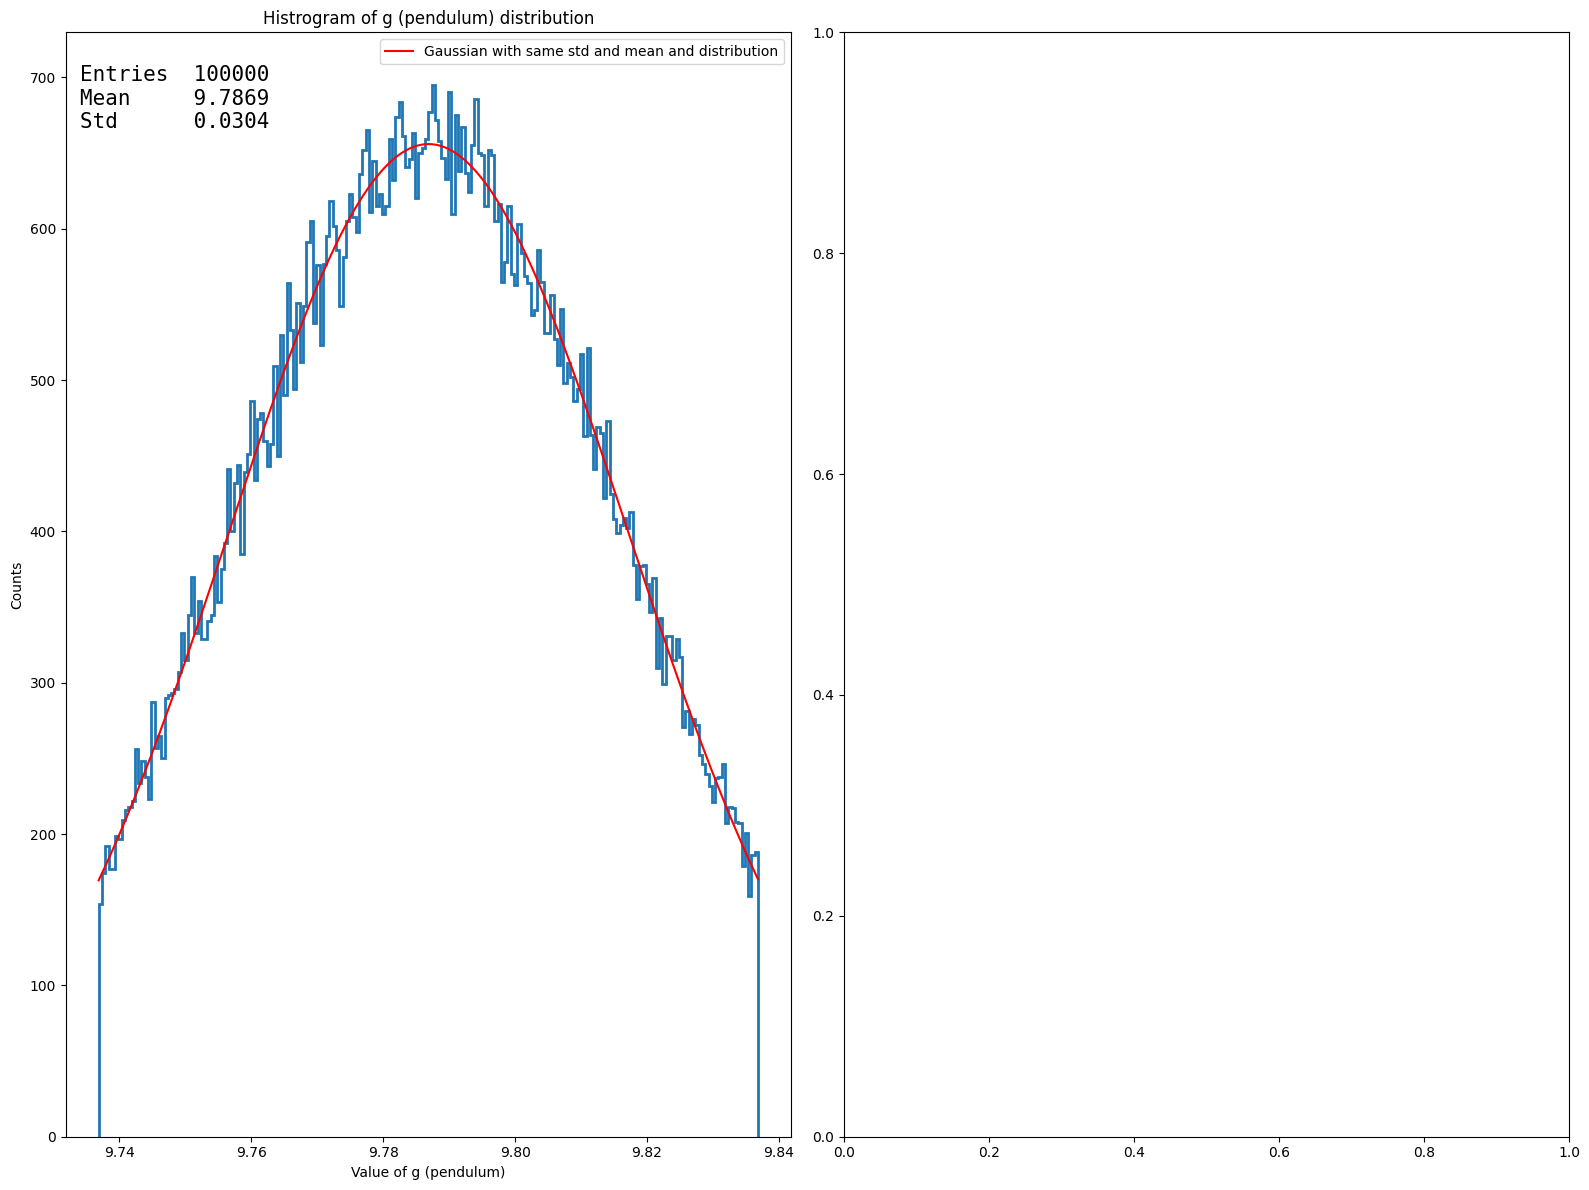

In [23]:
# Plot the probability distributions for the object functions

fig2, ax2 = plt.subplots(nrows = 1, ncols = 2, figsize = (16,12))

object_functions = [g_pendulum]
object_names = ['g (pendulum)', 'Circumference', 'digagonal', 'y1', 'y2']
g_pendulum_est = 4 * np.pi**2 * L / P **2

#Estimate some ranges and adjust afterwards
ranges = [(g_pendulum_est - 0.05, g_pendulum_est + 0.05)] 
#ranges = [(0,6), (0,10), (0,5)]
Nbins = [200]
means = []
stds = []
plot_gaussian = True

for f, range, bins, name, ax_i in zip(object_functions,ranges, Nbins, object_names, ax2.flatten()):
    ax_i.hist(f, bins = bins, range = range, histtype = 'step', linewidth = 2)
    ax_i.set(title = f'Histrogram of {name} distribution', xlabel = f'Value of {name}', ylabel = 'Counts')

    # Assuming a poisson uncertainty on each bin
    #bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    #s_count = np.sqrt(counts)
    meanf = f.mean()
    stdf = f.std()
    means.append(meanf)
    stds.append(stdf)

    d = {'Entries': N_exp, 'Mean': meanf, 'Std': stdf}
    text = nice_string_output(d, extra_spacing=2, decimals=4)
    add_text_to_ax(0.02, 0.97, text, ax_i, fontsize=15);

    if plot_gaussian:
        ## Fit Gaussians to the output variable distributions 
        x_range = np.linspace(range[0],range[1], 1000)
        y_vals = gaussian(x_range, N_exp, range, bins, meanf, stdf)
        ax_i.plot(x_range, y_vals, 'r-', label = f'Gaussian with same std and mean and distribution')
        ax_i.legend(loc = 'upper right')


fig2.tight_layout()

AttributeError: 'AxesSubplot' object has no attribute 'flatten'

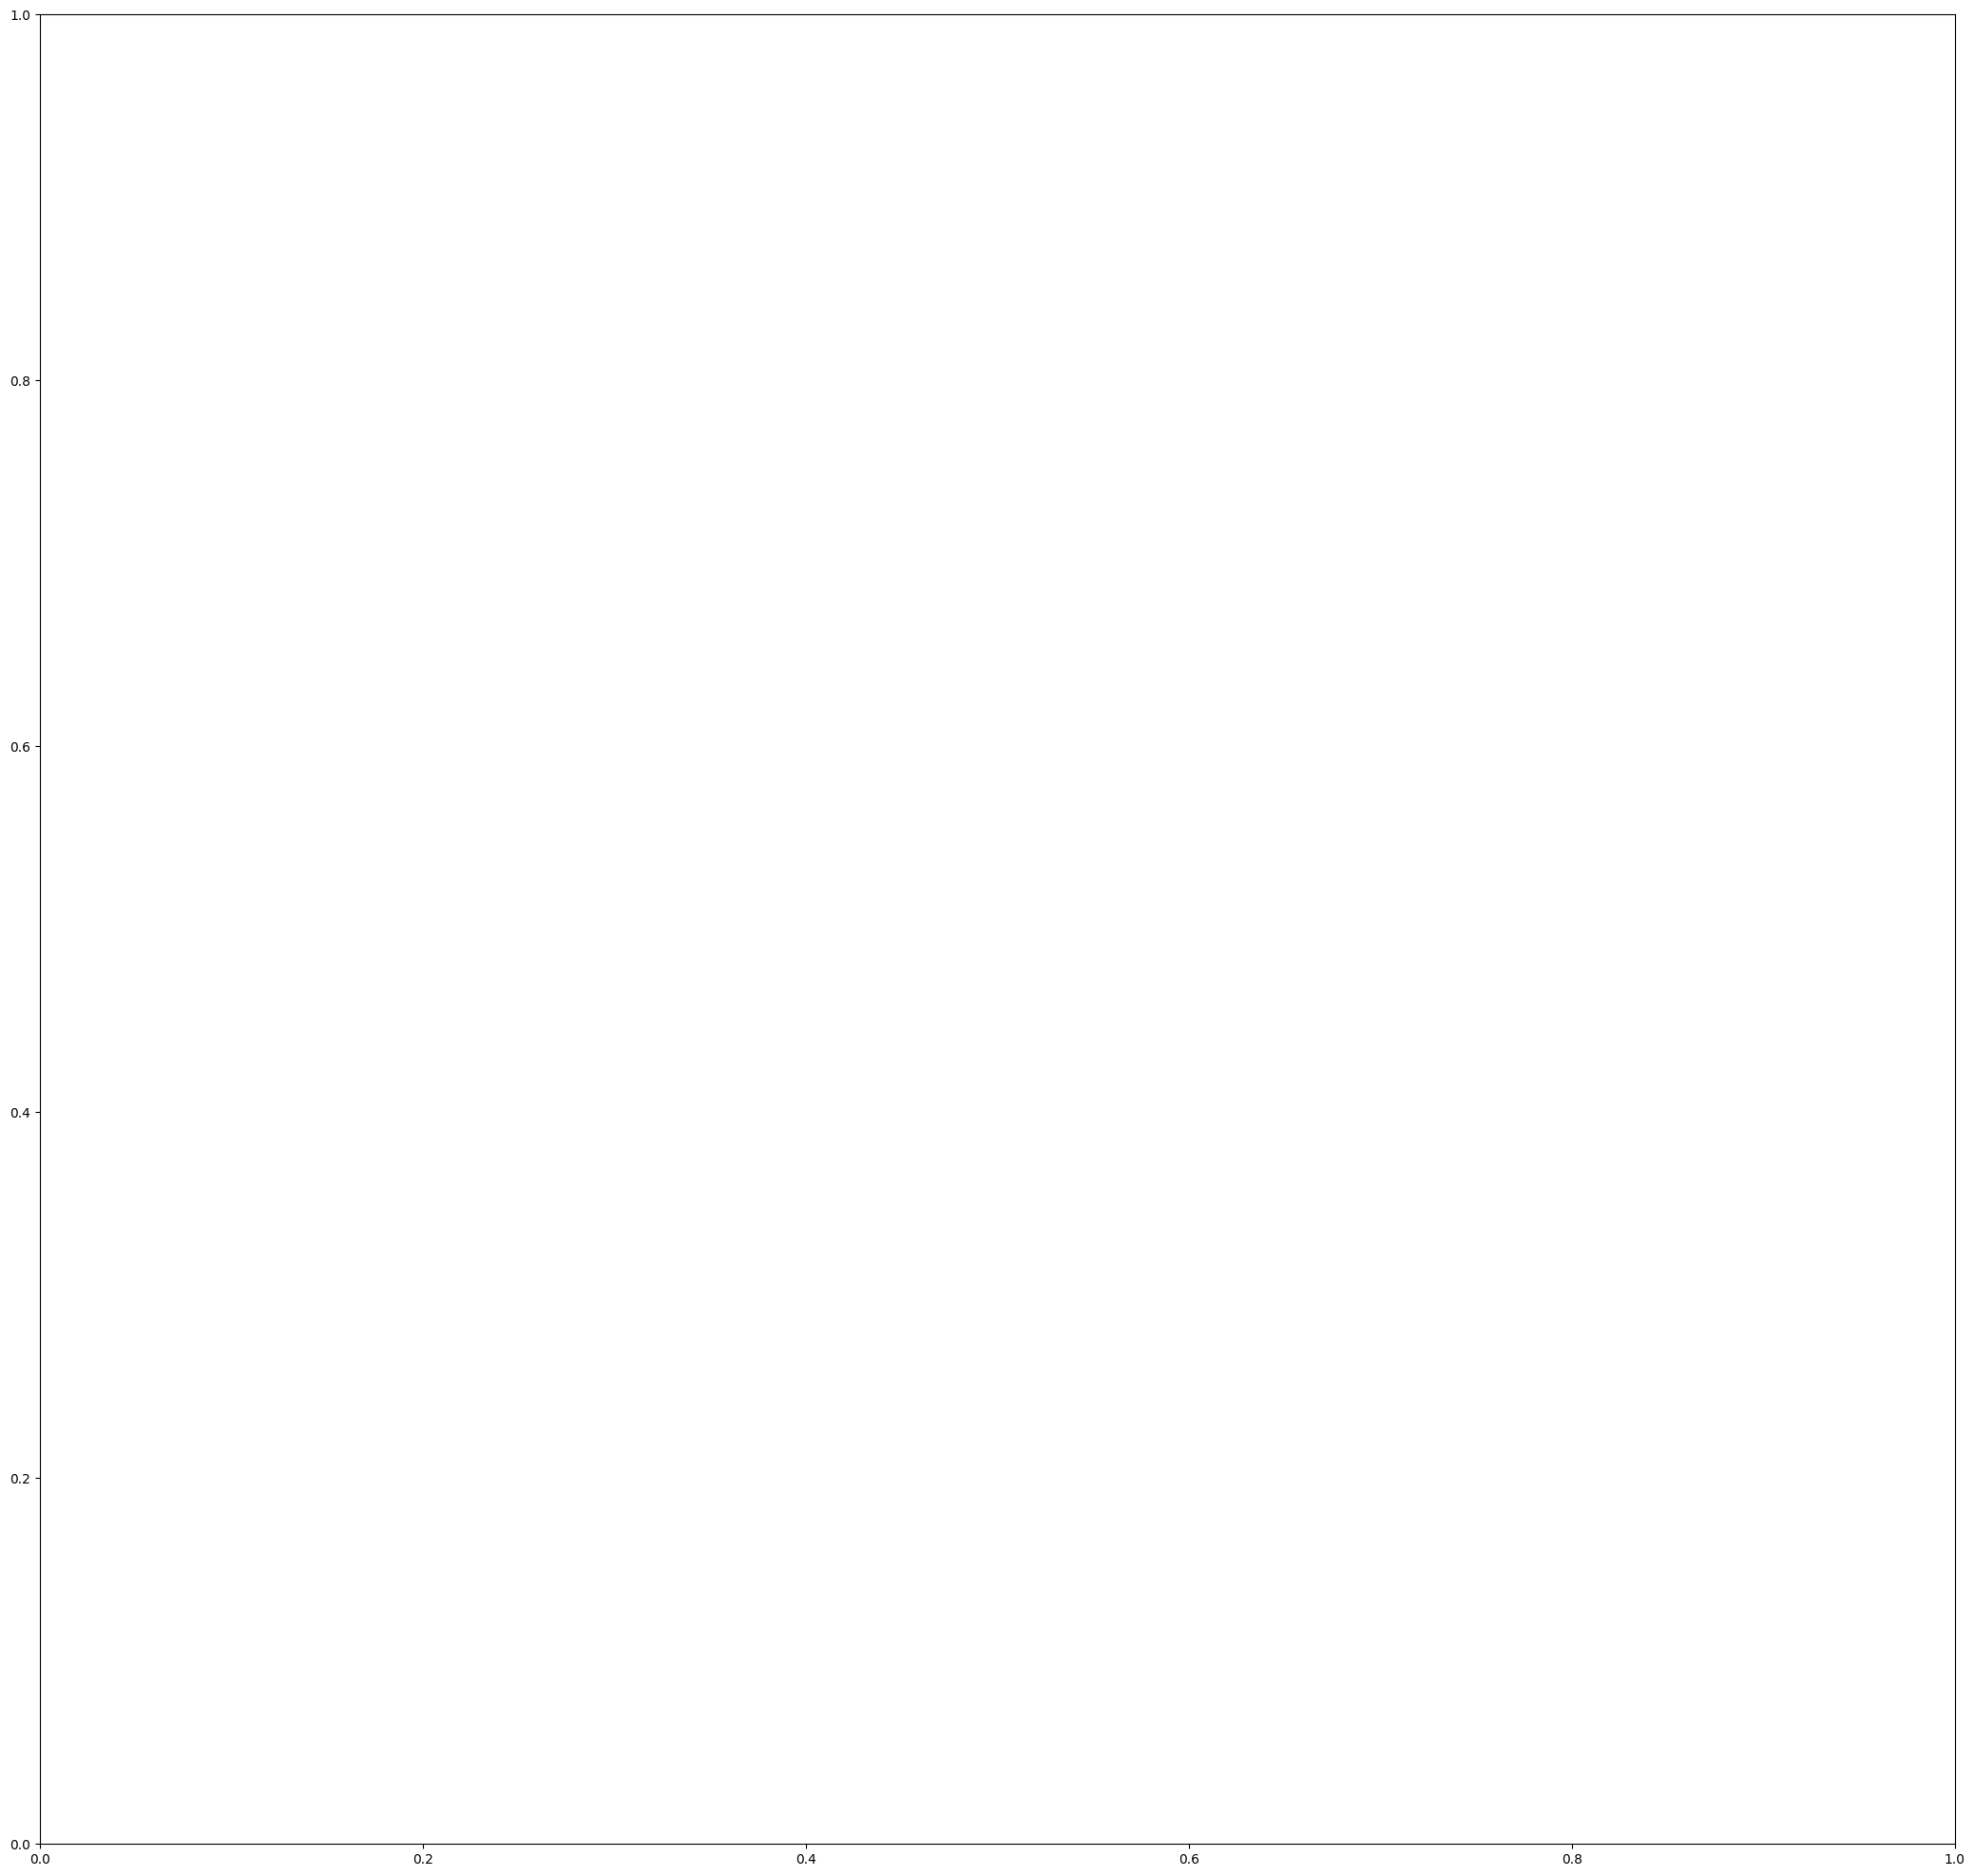

In [24]:
## Actually fitting a Gaussian and calculating goodness of fit
fig3, ax3 = plt.subplots(nrows = int(np.ceil(n_target / 2)), ncols = min(2,n_target), figsize = (26,25))


for f, range, bins, name, meanf, stdf, ax_i in zip(object_functions,ranges, Nbins, object_names, means, stds, ax3.flatten()):
    counts, bin_edges, _ = ax_i.hist(f, bins = bins, range = range, histtype = 'step', linewidth = 2)
    ax_i.set(title = f'Histrogram of {name} distribution', xlabel = f'Value of {name}', ylabel = 'Counts')

    # Assuming a poisson uncertainty on each bin
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    s = np.sqrt(counts)

    # Fight not_empty bins
    mask = (counts > 0)
  

    Chi2_object = Chi2Regression(lambda x, N, sigma, mu: gaussian(x, N, range, bins, mu, sigma), bin_centers[counts >0],
                                counts[counts >0], s[counts >0])


    ##ALTERNATIVE 
    #binned_likelihood = BinnedLH(lambda x, N, sigma, mu: gaussian(x, N, range, bins, mu, sigma), f, bins = bins, 
     #                   bound = (range[0], range[1]), extended=True)
    #fit = Minuit(binned_likelihood, N = N_exp, sigma = stdf, mu = meanf)

    fit = Minuit(Chi2_object, N = N_exp, sigma = stdf, mu = meanf)
    fit.errordef = Minuit.LEAST_SQUARES #=1
    fit.migrad() #perform fit

    N_fit, std_fit, mu_fit = fit.values[:]
    x_range = np.linspace(range[0], range[1], 1000)
    y_vals = gaussian(x_range, N_fit, range, bins, mu_fit, std_fit)
    ax_i.plot(x_range, y_vals, 'r-', label = 'Gaussian fit')
    ax_i.legend()
    
    
    
    NDOF = mask.sum() - len(fit.values[:])
    f_vals = gaussian(bin_centers, N_fit, range, bins, mu_fit, std_fit)

    #assuming the uncertainty in each value is given by Poisson statisticcs
    chi2val = np.sum(np.power(counts[mask] - f_vals[mask], 2) / np.power(s[mask],2))
    # OBS. Otherwise use minuit.fval to get chi2 val
    prop = stats.chi2.sf(chi2val, NDOF)

    d = {'Entries': N_exp, 'Sample Mean': meanf, ' Sample Std': stdf, 'Fit entries': [fit.values['N'], fit.errors['N']], 
    'Fit mu': [fit.values['mu'], fit.errors['mu']], 'Fit std': [fit.values['sigma'],fit.errors['sigma'] ], 'NDOF': NDOF, 'Chi2val': chi2val, 'Prop': prop}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.02, 0.97, text, ax_i, fontsize=15);

    

fig3.tight_layout()

### Problem:

Using values of x1 and x2, see the impact their variation has on Perimeter, Area, and Diameter, both without and with correlations. Determine the standard deviation of y, and see if it corresponds to your value from the initial calculation. Also check, if the distribution of y is Gaussian at all!

---

# Questions:

0. First solve the problem of obtaining the Perimeter, Area & Diagonal with uncertainty ANALYTICALLY.

1. Now look at the program, and assure yourself that you understand what is going on. Put in the correct expression for y in terms of x1=L and x2=W in order to calculate the circumference, area, and diagonal length, and run the program. Does the output correspond well with the results you expected from your analytical calculations to begin with?

2. Imagine that you wanted to know the central value and uncertainty of y1 and y2, given the
   same above PDFs for `x1`=$L$ and `x2`=$W$:
   
     `y1 = log(square(x1*tan(x2))+sqrt((x1-x2)/(cos(x2)+1.0+x1)))`
     
     `y2 = 1.1+sin(20*x1)`

   Get the central value of y, and see if you can quickly differentiate this with
   respect to `x1` and `x2`, and thus predict what uncertainty to expect for y using
   the error propagation formula. It is (for once) OK to give up on the first expression :-)
   Next, try to estimate the central value and uncertainty using random numbers
   like above - do you trust this result more? And are the distributions Gaussian?


### Advanced questions:

3. Try to generate `x1` and `x2` with non-linear correlation, which yields zero linear correlation,
   and see that despite not having any linear correlation, the result on perimeter, area, and diagonal
   length is still affected.


# Learning points:

Through this exercise, you should understand, that uncertainties (errors in slang) propagation can be in **two ways**:
1. **Analytically**, propergating the uncertainties by differentiating the formula/relation in question.
2. **Numerically** (i.e. simulation), by using random numbers reflecting the uncertainties on the input parameters, and calculating the final resulting number many times from these, noting the variation.

The analytical method is simple and transparent, but not always robust, as it requires that the error propagation formula holds. The numerical method is simple and robust, but not transparent. Using both methods is a great way of cross checking.

Finally, you should understand, that error propagation plays an essential role in science, and that it is also used in planning of experiments (to minimise the error on the final quantity of interest).